In [87]:
BASE_INFO_PATH = r"..\user_weibo_data_cleaned"
SENTI_ANALY_PATH = r"..\LLM_Analysis\result\ds_analysis"

USER_INFO_FILE = "user_cleaned.csv"
WEIBO_INFO_FILE = "weibo_cleaned.csv"

In [88]:
import os
import pandas as pd
import json


def load_and_preprocess_data():
    """Load and preprocess user and Weibo data.

    Returns:
        tuple: A tuple containing the preprocessed user DataFrame, Weibo DataFrame, and a list of error user IDs.
    """
    # 读取数据
    df_user = pd.read_csv(os.path.join(BASE_INFO_PATH, USER_INFO_FILE))
    df_weibo = pd.read_csv(os.path.join(BASE_INFO_PATH, WEIBO_INFO_FILE))
    
    # 转换数据类型
    df_weibo["created_at"] = pd.to_datetime(df_weibo["created_at"])
    df_user["uid"] = df_user["uid"].astype("str")
    df_weibo["uid"] = df_weibo["uid"].astype("str")
    df_weibo["wid"] = df_weibo["wid"].astype("str")
    
    # 过滤ERROR用户
    error_user_ids = df_user[df_user["error"] == 1]["uid"].tolist()
    df_user = df_user[df_user["error"] != 1]
    df_weibo = df_weibo[~df_weibo["uid"].isin(error_user_ids)]
    
    return df_user, df_weibo, error_user_ids


def load_sentiment_analysis(error_user_ids):
    """Load sentiment analysis results.

    Args:
        error_user_ids (list): A list of user IDs that encountered errors.

    Returns:
        dict: A dictionary containing sentiment analysis results for each user.
    """
    sentiment_analysis_dict = {}
    for i in range(1, 8):
        file_name = f"ds_{i}.json"
        file_path = os.path.join(SENTI_ANALY_PATH, file_name)
        with open(file_path, 'r', encoding='utf-8') as f:
            sentiment_analysis_dict.update(json.load(f))
    sentiment_analysis_dict = {uid: info for uid, info in sentiment_analysis_dict.items() if uid not in error_user_ids}
    return sentiment_analysis_dict


def process_sentiment_type(sentiment_analysis_dict: dict):
    """Process sentiment types in the sentiment analysis dictionary.

    Args:
        sentiment_analysis_dict (dict): A dictionary containing sentiment analysis results.

    Returns:
        dict: The updated sentiment analysis dictionary with processed sentiment types.
    """
    for info in sentiment_analysis_dict.values():
        for analysis in info.values():
            comp_sentiment = analysis.get('comprehensive_sentiment', {})
            aspect_sentiment = analysis.get('aspect_sentiment', {})

            if comp_sentiment:
                try:
                    sentiment_type = comp_sentiment.get('type', '')
                    sentiment_list = sentiment_type.split('-')
                    # if len(sentiment_list) == 2:
                    #     main_type, sub_type = sentiment_list
                    if len(sentiment_list) == 3:
                        # print(f"情感类型：{sentiment_type}")
                        comp_sentiment, aspect_sentiment = sentiment_type.split('/')
                        # main_type, sub_type = comp_sentiment.split('-')
                        analysis["comprehensive_sentiment"]["type"] = comp_sentiment
                        analysis["aspect_sentiment"].update({aspect_sentiment: "待定"})
                        # print(f'修改后：{analysis["comprehensive_sentiment"]["type"]}, {analysis["aspect_sentiment"]}')
                        # print()
                    # else:
                    #     main_type = sentiment_type
                except Exception as e:
                    print("Error parsing sentiment type:", e)

    return sentiment_analysis_dict

In [89]:
class SentimentAnalysis:
    def __init__(self, analysis_dict):
        # self.created_at = analysis_dict.get("created_at")
        # self.post_interval = analysis_dict.get("post_interval")
        self.mentions = analysis_dict.get("mentions", [])
        self.topics = analysis_dict.get("topics", [])
        self.comprehensive_sentiment = analysis_dict.get("comprehensive_sentiment", {})
        self.aspect_sentiment = analysis_dict.get("aspect_sentiment", {})
        self.narrative_threads = analysis_dict.get("narrative_threads", [])


class Weibo:
    def __init__(self, wid, uid, text, created_at, attitudes_count, comments_count, reposts_count, sentiment_analysis=None):
        self.wid = wid
        self.uid = uid
        self.text = text
        self.created_at = created_at
        self.attitudes_count = attitudes_count
        self.comments_count = comments_count
        self.reposts_count = reposts_count

        self.mentions = sentiment_analysis.mentions if sentiment_analysis else []
        self.topics = sentiment_analysis.topics if sentiment_analysis else []
        self.sentiment_analysis = sentiment_analysis

class User:
    def __init__(self, uid, screen_name, gender, statuses_count, IP):
        self.uid = uid
        self.screen_name = screen_name
        self.gender = gender
        self.statuses_count = statuses_count
        self.IP = IP
        self.weibos = []

    def add_weibo(self, weibo):
        self.weibos.append(weibo)


def build_user_objects(df_user, df_weibo, sentiment_analysis_dict):
    # 使用字典推导式快速构建user_dict
    user_dict = {
        str(row['uid']): User(
            uid=row['uid'],
            screen_name=row['screen_name'],
            gender=row['gender'],
            statuses_count=row['statuses_count'],
            IP=row['IP']
        )
        for _, row in df_user.iterrows()
    }
    
    # 预先创建情感分析查找字典，避免重复查找
    sentiment_lookup = {}
    for uid, user_sentiments in sentiment_analysis_dict.items():
        sentiment_lookup[uid] = {
            wid: SentimentAnalysis(sentiment_data)
            for wid, sentiment_data in user_sentiments.items()
        }
    
    # 批量处理微博数据
    for _, row in df_weibo.iterrows():
        uid = str(row['uid'])
        wid = str(row['wid'])
        
        # 快速查找情感分析
        sentiment = None
        if uid in sentiment_lookup and wid in sentiment_lookup[uid]:
            sentiment = sentiment_lookup[uid][wid]
        
        # 创建Weibo对象
        weibo = Weibo(
            wid=row['wid'],
            uid=row['uid'],
            text=row['text'],
            created_at=row['created_at'],
            attitudes_count=row['attitudes_count'],
            comments_count=row['comments_count'],
            reposts_count=row['reposts_count'],
            sentiment_analysis=sentiment
        )
        
        # 添加到用户
        if uid in user_dict:
            user_dict[uid].add_weibo(weibo)
    
    return user_dict

In [90]:
# 读取用户与微博数据
df_user, df_weibo, error_user_ids = load_and_preprocess_data()

In [91]:
# 获取情感分析数据
sentiment_analysis_dict = load_sentiment_analysis(error_user_ids)

# 处理情感类型分析
sentiment_analysis_dict = process_sentiment_type(sentiment_analysis_dict)

In [92]:
# 构建用户对象
user_dict = build_user_objects(df_user, df_weibo, sentiment_analysis_dict)

In [93]:
from collections import Counter

class UserProfile:
    def __init__(self, user):
        self.user = user
        self.basic_info = self._analyze_basic_info()
        self.behavior_patterns = self._analyze_behavior_patterns()
        self.content_preferences = self._analyze_content_preferences()
        self.emotional_profile = self._analyze_emotional_profile()
        self.social_network = self._analyze_social_network()
        self.activity_patterns = self._analyze_activity_patterns()
    
    def _analyze_basic_info(self):
        """基础信息分析"""
        return {
            'uid': self.user.uid,
            'screen_name': self.user.screen_name,
            'gender': self.user.gender,
            'statuses_count': self.user.statuses_count,
            'IP_location': self.user.IP,
            'total_weibos': len(self.user.weibos),
            'active_days': self._calculate_active_days(),
            'avg_weibos_per_day': round(len(self.user.weibos) / self._calculate_active_days(), 2)
            # 'avg_weibos_per_day': round(len(self.user.weibos) / max(self._calculate_active_days()), 1)
        }
    
    def _analyze_behavior_patterns(self):
        """行为模式分析"""
        if not self.user.weibos:
            return {}
        
        # 发布时间分布
        posting_hours = [weibo.created_at.hour for weibo in self.user.weibos]
        posting_days = [weibo.created_at.strftime('%A') for weibo in self.user.weibos]

        most_active_hour = Counter(posting_hours).most_common(1)[0]
        most_active_day = Counter(posting_days).most_common(1)[0]

        return {
            'most_active_hour': most_active_hour[0],
            'most_active_hour_ratio': round(most_active_hour[1] / len(posting_hours), 2),
            'most_active_day': most_active_day[0],
            'most_active_day_ratio': round(most_active_day[1] / len(posting_days), 2),
            'avg_posting_interval_hour': self._calculate_posting_interval(),
            'posting_regularity': self._calculate_posting_regularity(),
            'weekend_activity_ratio': self._calculate_weekend_activity(),
            'night_activity_ratio': self._calculate_night_activity()
        }
    
    def _analyze_content_preferences(self):
        """内容偏好分析"""
        if not self.user.weibos:
            return {}
        
        # 文本长度分析
        text_lengths = [len(weibo.text) for weibo in self.user.weibos]
        
        # 互动数据统计
        total_attitudes = sum(weibo.attitudes_count for weibo in self.user.weibos)
        total_comments = sum(weibo.comments_count for weibo in self.user.weibos)
        total_reposts = sum(weibo.reposts_count for weibo in self.user.weibos)
        
        return {
            'avg_text_length': round(sum(text_lengths) / len(text_lengths), 2),
            'max_text_length': max(text_lengths),
            'min_text_length': min(text_lengths),
            'total_interactions': total_attitudes + total_comments + total_reposts,
            'avg_attitudes_per_weibo': round(total_attitudes / len(self.user.weibos), 2),
            'avg_comments_per_weibo': round(total_comments / len(self.user.weibos), 2),
            'avg_reposts_per_weibo': round(total_reposts / len(self.user.weibos), 2),
            # 'interaction_ratio': round((total_attitudes + total_comments + total_reposts) / len(self.user.weibos), 2)
        }
    
    def _analyze_emotional_profile(self):
        """情感画像分析"""
        # 统计有情感分析的微博
        sentiment_weibos = [w for w in self.user.weibos if w.sentiment_analysis]
        
        
        # 情感类型统计
        sentiment_main_types = []
        sentiment_sub_types = []
        # sentiment_intensities = []
        sentiment_values = []
        event_categories = []
        keywords = []
        
        for weibo in sentiment_weibos:
            try:
                comp_sentiment = weibo.sentiment_analysis.comprehensive_sentiment
                if comp_sentiment:
                    sentiment_type = comp_sentiment.get('type', '')
                    if '-' in sentiment_type:
                        main_type, sub_type = sentiment_type.split('-')
                    else:
                        main_type = sentiment_type
                        sub_type = ''

                if main_type == '积极':
                    sentiment_value = 1
                elif main_type == '消极':
                    sentiment_value = -1
                else:
                    sentiment_value = 0
                
                base_value = 5.0
                sentiment_intensity = comp_sentiment.get("intensity", 0)
                sentiment_value = base_value + sentiment_value * sentiment_intensity * 0.5

                sentiment_main_types.append(main_type)
                sentiment_sub_types.append(sub_type)
                sentiment_values.append(sentiment_value)
                
                # sentiment_types.append(comp_sentiment.get('type', ''))
                # sentiment_intensities.append(comp_sentiment.get('intensity', 0))
                event_categories.append(comp_sentiment.get('event_category', ''))
                keywords.extend(comp_sentiment.get('keywords', []))
        
            except Exception as e:
                uid = self.user.uid
                wid = weibo.wid
                print(f"解析用户 {uid} 的微博 {wid} 时出现错误：{e}")


        top1_event_category, top1_event_category_ratio = self._get_top_items(event_categories, 1)[0]

        return {
            # 'has_sentiment_data': True,
            # 'dominant_sentiment': max(set(sentiment_types), key=sentiment_types.count) if sentiment_types else None,
            'avg_sentiment_value': round(sum(sentiment_values) / len(sentiment_values), 2),
            'top1_event_category': top1_event_category,
            'top1_event_category_ratio': top1_event_category_ratio,
            'top_event_categories': self._get_top_items(event_categories, 5),
            # 'top_keywords': self._get_top_items(keywords, 10),
            'sentiment_stability': self._calculate_sentiment_stability(sentiment_main_types),
            'positive_ratio': round(sentiment_main_types.count("积极") / len(sentiment_main_types),2),
            'negative_ratio': round(sentiment_main_types.count("消极") / len(sentiment_main_types), 2) 
            # 'neutral_ratio': sentiment_main_types.count("中性") / len(sentiment_main_types),
        }
    
    def _analyze_social_network(self):
        """社交网络分析"""
        # 基于互动数据推断社交活跃度
        total_interactions = sum(
            weibo.attitudes_count + weibo.comments_count + weibo.reposts_count 
            for weibo in self.user.weibos
        )

        mentions = []
        topics = []

        for weibo in self.user.weibos:
            mentions.extend(weibo.mentions)
            topics.extend(weibo.topics)

        return {
            'social_activity_level': self._categorize_social_level(total_interactions),
            'avg_interactions_per_weibo': round(total_interactions / len(self.user.weibos), 2) if self.user.weibos else 0,
            # 'engagement_rate': round(total_interactions / (len(self.user.weibos) * 100), 2) if self.user.weibos else 0  # 假设平均曝光100次
            'mentions': mentions, 
            'mention_count': len(mentions), 
            'distinct_mention_count': len(set(mentions)), 
            'topics': topics,
            'topic_count': len(topics), 
            'distinct_topic_count': len(set(topics)),
        }
    
    def _analyze_activity_patterns(self):
        """活动模式分析"""
        if not self.user.weibos:
            return {}
        
        # 按月份统计活动
        monthly_activity = {}
        for weibo in self.user.weibos:
            month = weibo.created_at.strftime('%Y-%m')
            monthly_activity[month] = monthly_activity.get(month, 0) + 1
        
        return {
            'most_active_month': max(monthly_activity.items(), key=lambda x: x[1])[0] if monthly_activity else None,
            'activity_trend': self._calculate_activity_trend(monthly_activity),
            'consistency_score': self._calculate_consistency_score(monthly_activity)
        }
    
    # 辅助方法
    def _calculate_active_days(self):
        """计算活跃天数"""
        if not self.user.weibos:
            return 0
        unique_days = set(weibo.created_at.date() for weibo in self.user.weibos)
        return len(unique_days)
    
    def _calculate_posting_interval(self):
        """计算平均发帖间隔（小时）"""
        if len(self.user.weibos) < 2:
            return 0
        
        sorted_weibos = sorted(self.user.weibos, key=lambda x: x.created_at)
        intervals = []
        for i in range(1, len(sorted_weibos)):
            interval = (sorted_weibos[i].created_at - sorted_weibos[i-1].created_at).total_seconds() / 3600  # 小时
            intervals.append(interval)
        
        return round(sum(intervals) / len(intervals), 2) if intervals else 0
    
    def _calculate_posting_regularity(self):
        """计算发帖规律性，若发帖间隔均匀，则认为发帖规律，值越接近1则发帖越规律"""
        
        intervals = []
        sorted_weibos = sorted(self.user.weibos, key=lambda x: x.created_at)
        for i in range(1, len(sorted_weibos)):
            interval = (sorted_weibos[i].created_at - sorted_weibos[i-1].created_at).total_seconds() / 3600
            intervals.append(interval)
        
        # 计算间隔的标准差，越小越规律
        if not intervals:
            return 0
        mean_interval = sum(intervals) / len(intervals)
        variance = sum((x - mean_interval) ** 2 for x in intervals) / len(intervals)
        return round(1 / (1 + variance), 5)  # 归一化，值越大越规律
    
    def _calculate_weekend_activity(self):
        """计算周末活动比例"""
        weekend_posts = sum(1 for weibo in self.user.weibos if weibo.created_at.weekday() >= 5)
        return round(weekend_posts / len(self.user.weibos), 2)
    
    def _calculate_night_activity(self):
        """计算夜间活动比例（22:00-06:00）"""
        night_posts = sum(1 for weibo in self.user.weibos 
                         if weibo.created_at.hour >= 22 or weibo.created_at.hour <= 6)
        return round(night_posts / len(self.user.weibos), 2)
    
    def _get_top_items(self, items, top_n):
        """获取出现频率最高的前N项"""
        from collections import Counter
        counter = Counter(items)
        return [(item, round(count / len(items), 2)) for item, count in counter.most_common(top_n)]
    
    def _calculate_sentiment_stability(self, sentiment_types):
        """计算情感稳定性，值越接近1则情感越稳定"""      
        # 计算情感类型变化频率
        changes = sum(1 for i in range(1, len(sentiment_types)) 
                    if sentiment_types[i] != sentiment_types[i-1])
        return round(1 - (changes / (len(sentiment_types) - 1)), 2)
    
    def _categorize_social_level(self, total_interactions):
        """社交活跃度分类"""
        if total_interactions >= 1000:
            return "高活跃"
        elif total_interactions >= 100:
            return "中活跃"
        else:
            return "低活跃"
    
    def _calculate_activity_trend(self, monthly_activity):
        """计算活动趋势"""
        if len(monthly_activity) < 2:
            return "稳定"
        
        months = sorted(monthly_activity.keys())
        first_month_count = monthly_activity[months[0]]
        last_month_count = monthly_activity[months[-1]]
        
        if last_month_count > first_month_count * 1.5:
            return "上升"
        elif last_month_count < first_month_count * 0.7:
            return "下降"
        else:
            return "稳定"
    
    def _calculate_consistency_score(self, monthly_activity):
        """计算一致性得分"""
        if not monthly_activity:
            return 0
        
        values = list(monthly_activity.values())
        mean_value = sum(values) / len(values)
        variance = sum((x - mean_value) ** 2 for x in values) / len(values)
        return 1 / (1 + variance)  # 归一化
    
    def get_summary(self):
        """获取用户画像摘要"""
        return {
            'basic_info': self.basic_info,
            'behavior_patterns': self.behavior_patterns,
            'content_preferences': self.content_preferences,
            'emotional_profile': self.emotional_profile,
            'social_network': self.social_network,
            # 'activity_patterns': self.activity_patterns
        }
    
    def get_user_type(self):
        """获取用户类型标签"""
        labels = []
        
        # 基于活跃度
        if self.basic_info['avg_weibos_per_day'] > 2:
            labels.append("高频用户")
        elif self.basic_info['avg_weibos_per_day'] < 0.1:
            labels.append("低频用户")
        else:
            labels.append("中频用户")
        
        # 基于情感特征
        if self.emotional_profile.get('positive_ratio', 0) > 0.6:
            labels.append("积极用户")
        elif self.emotional_profile.get('negative_ratio', 0) > 0.6:
            labels.append("消极用户")
        
        # 基于社交活跃度
        labels.append(self.social_network['social_activity_level'])
        
        # 基于活动时间
        if self.behavior_patterns.get('night_activity_ratio', 0) > 0.3:
            labels.append("夜猫子")
        
        return labels

In [94]:
profile_list = [UserProfile(user) for user in user_dict.values()]

In [11]:
import random

random.choice(profile_list).get_summary()

{'basic_info': {'uid': '5969000003',
  'screen_name': '用户5969000003',
  'gender': 'm',
  'statuses_count': 133,
  'IP_location': '陕西',
  'total_weibos': 50,
  'active_days': 48,
  'avg_weibos_per_day': 1.04},
 'behavior_patterns': {'most_active_hour': 8,
  'most_active_hour_ratio': 0.34,
  'most_active_day': 'Friday',
  'most_active_day_ratio': 0.18,
  'avg_posting_interval_hour': 25.52,
  'posting_regularity': 0.00864,
  'weekend_activity_ratio': 0.28,
  'night_activity_ratio': 0.06},
 'content_preferences': {'avg_text_length': 101.16,
  'max_text_length': 402,
  'min_text_length': 42,
  'total_interactions': 1,
  'avg_attitudes_per_weibo': 0.0,
  'avg_comments_per_weibo': 0.02,
  'avg_reposts_per_weibo': 0.0},
 'emotional_profile': {'avg_sentiment_value': 3.37,
  'top1_event_category': '个人情感',
  'top1_event_category_ratio': 0.24,
  'top_event_categories': [('个人情感', 0.24),
   ('社交互动', 0.18),
   ('日常生活', 0.16),
   ('个人状态', 0.08),
   ('个人健康', 0.06)],
  'sentiment_stability': 0.41,
  'po

In [12]:
# 将所有用户画像摘要转换为DataFrame
profile_dict_list = [profile.get_summary() for profile in profile_list]
df_profile = pd.json_normalize(profile_dict_list)
df_profile.head()

,basic_info.uid,basic_info.screen_name,basic_info.gender,basic_info.statuses_count,basic_info.IP_location,basic_info.total_weibos,basic_info.active_days,basic_info.avg_weibos_per_day,behavior_patterns.most_active_hour,behavior_patterns.most_active_hour_ratio,...,emotional_profile.positive_ratio,emotional_profile.negative_ratio,social_network.social_activity_level,social_network.avg_interactions_per_weibo,social_network.mentions,social_network.mention_count,social_network.distinct_mention_count,social_network.topics,social_network.topic_count,social_network.distinct_topic_count
0,1000129923,重铸无限城荣光,f,7991,湖南,50,11,4.55,0,0.14,...,0.26,0.52,低活跃,1.98,[],0,0,[],0,0
1,1004171625,财欣欣666,f,536,四川,33,9,3.67,7,0.18,...,0.55,0.15,高活跃,137.64,[财宝宝],1,1,"[生活手记, 金价, 微博账号异常, 微博账号异常怎么解除, 生活手记, 热点, 生活手记,...",29,23
2,1005603481,青岛金笑笑,f,3867,山东,46,25,1.84,12,0.17,...,0.09,0.65,低活跃,1.22,[],0,0,[产后妈妈的缺觉困境],1,1
3,1006429701,彗星划过的一颗粉尘,f,3013,湖南,47,32,1.47,20,0.15,...,0.43,0.32,低活跃,0.45,[],0,0,[],0,0
4,1007473540,春稳王,m,521,北京,22,22,1.00,21,0.27,...,0.77,0.09,低活跃,2.18,"[崔珊珊__, 崔珊珊__, 崔珊珊__]",3,1,"[奥运会乒乓球混双决赛, 七夕, 中秋, 好东西, 胖东来攻入北京, 豆花, 秦炉, 元宵节...",9,9


In [13]:
screen_name_list = [profile.basic_info["screen_name"] for profile in profile_list]

for profile in profile_list:
    screen_name = profile.basic_info["screen_name"]
    mentions = profile.social_network.get("mentions", [])
    if mentions:
        related_users = set([user for user in mentions if user in screen_name_list and user != screen_name])
        if related_users:
            print(f"用户 {screen_name} 提及了其他用户：{related_users}")

用户 站在村口的乔治 提及了其他用户：{'一只小抱扑'}
用户 阿林林喜欢猫猫周 提及了其他用户：{'江湖路远--'}
用户 请叫我Ms睡不醒 提及了其他用户：{'就不摸绵羊'}
用户 屁嘞噗噗 提及了其他用户：{'周小超啦'}
用户 就不摸绵羊 提及了其他用户：{'请叫我Ms睡不醒'}
用户 Rebeca_Q 提及了其他用户：{'十日o3o'}
用户 白鹅余鹅记录簿 提及了其他用户：{'一罐起司糖'}
用户 夜雪潇月-何以倾城 提及了其他用户：{'米米妈育儿'}
用户 周小超啦 提及了其他用户：{'屁嘞噗噗'}
用户 京畿道桜季_婧候乔青羽版 提及了其他用户：{'那就拥抱橘子熊'}
用户 一罐起司糖 提及了其他用户：{'白鹅余鹅记录簿'}
用户 长空夕醉ing 提及了其他用户：{'砚徵书笙'}
用户 英国小伙互殴七年可以结婚 提及了其他用户：{'我只屬於你在這短暫的生命_'}
用户 美男v我50万 提及了其他用户：{'少女6只猫之宠物沟通师99解答1次'}
用户 不要温顺地走进那个良夜- 提及了其他用户：{'吒团一'}
用户 砚徵书笙 提及了其他用户：{'长空夕醉ing'}
用户 到底要睡多久才能不困- 提及了其他用户：{'泡芙羊o'}
用户 501碎 提及了其他用户：{'翎允曦'}
用户 财智贤 提及了其他用户：{'财甜呀', '叮铃铃uu'}


In [14]:
df_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13227 entries, 0 to 13226
Data columns (total 38 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   basic_info.uid                               13227 non-null  object 
 1   basic_info.screen_name                       13227 non-null  object 
 2   basic_info.gender                            13227 non-null  object 
 3   basic_info.statuses_count                    13227 non-null  int64  
 4   basic_info.IP_location                       13227 non-null  object 
 5   basic_info.total_weibos                      13227 non-null  int64  
 6   basic_info.active_days                       13227 non-null  int64  
 7   basic_info.avg_weibos_per_day                13227 non-null  float64
 8   behavior_patterns.most_active_hour           13227 non-null  int64  
 9   behavior_patterns.most_active_hour_ratio     13227 non-null  float64
 10

In [15]:
# 提取省份字段（假设IP_location格式为"省份/城市"或"省份"）
df_profile['省份'] = df_profile['basic_info.IP_location'].str.split('/').str[0]
print("处理后的省份数据示例：")
print(df_profile['省份'].value_counts().head())  # 查看省份分布前几名

处理后的省份数据示例：
省份
广东    1946
浙江    1126
江苏    1040
上海     948
北京     931
Name: count, dtype: int64


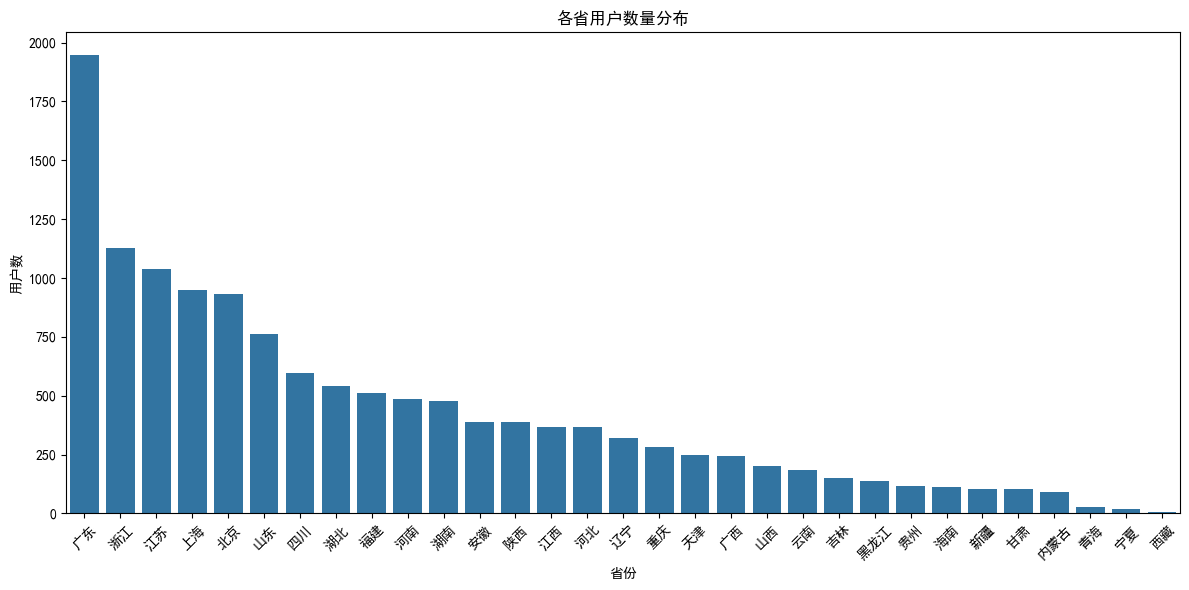

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置matplotlib显示中文
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']  # 任选其一即可
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12,6))
province_counts = df_profile['basic_info.IP_location'].value_counts()
sns.barplot(x=province_counts.index, y=province_counts.values)
plt.xticks(rotation=45)
plt.title('各省用户数量分布')
plt.ylabel('用户数')
plt.xlabel('省份')
plt.tight_layout()
plt.show()

In [ ]:
def get_most_common(series):
    return series.mode().iloc[0] if not series.empty else None

aggregate_map = {
    'basic_info.uid': 'count',
    'basic_info.statuses_count': 'mean',
    'basic_info.active_days': 'mean',
    'basic_info.avg_weibos_per_day': 'mean',
    'behavior_patterns.most_active_hour': 'mean',
    'behavior_patterns.most_active_day': lambda x: get_most_common(x),
    'behavior_patterns.avg_posting_interval_hour': 'mean',
    'behavior_patterns.posting_regularity': 'mean',
    'behavior_patterns.weekend_activity_ratio': 'mean',
    'behavior_patterns.night_activity_ratio': 'mean',
    'content_preferences.avg_text_length': 'mean',
    'content_preferences.max_text_length': 'mean',
    'content_preferences.min_text_length': 'mean',
    'content_preferences.total_interactions': 'mean',
    'content_preferences.avg_attitudes_per_weibo': 'mean',
    'content_preferences.avg_comments_per_weibo': 'mean',
    'content_preferences.avg_reposts_per_weibo': 'mean',
    'emotional_profile.avg_sentiment_value': 'mean',
    'emotional_profile.top1_event_category': lambda x: get_most_common(x),
    'emotional_profile.sentiment_stability': 'mean',
    'emotional_profile.positive_ratio': 'mean',
    'emotional_profile.negative_ratio': 'mean',
    'social_network.avg_interactions_per_weibo': 'mean',
    'social_network.mention_count': 'mean',
    'social_network.topic_count': 'mean',
    'social_network.distinct_topic_count': 'mean'
}

rename_map = {
    'basic_info.uid': '用户数',
    'basic_info.IP_location': '省份',
    'basic_info.statuses_count': '微博总数',
    'basic_info.active_days': '活跃天数',
    'basic_info.avg_weibos_per_day': '日均微博数',
    'behavior_patterns.most_active_hour': '最活跃小时',
    'behavior_patterns.most_active_day': '最活跃日',
    'behavior_patterns.avg_posting_interval_hour': '平均发帖间隔小时',
    'behavior_patterns.posting_regularity': '发帖规律度',
    'behavior_patterns.weekend_activity_ratio': '周末活跃度',
    'behavior_patterns.night_activity_ratio': '夜间活跃度',
    'content_preferences.avg_text_length': '平均文本长度',
    'content_preferences.max_text_length': '最大文本长度',
    'content_preferences.min_text_length': '最小文本长度',
    'content_preferences.total_interactions': '总互动数',
    'content_preferences.avg_attitudes_per_weibo': '平均每微博点赞数',
    'content_preferences.avg_comments_per_weibo': '平均每微博评论数',
    'content_preferences.avg_reposts_per_weibo': '平均每微博转发数',
    'emotional_profile.avg_sentiment_value': '平均情感值',
    'emotional_profile.top1_event_category': '事件类别',
    'emotional_profile.sentiment_stability': '情感稳定性',
    'emotional_profile.positive_ratio': '正向情感比例',
    'emotional_profile.negative_ratio': '负向情感比例',
    'social_network.avg_interactions_per_weibo': '平均每微博互动数',
    'social_network.mention_count': '@用户数',
    'social_network.topic_count': '话题数',
    'social_network.distinct_topic_count': '独立话题数'
}


In [20]:
# 按省份对性别进行分组统计
gender_stats = df_profile.groupby(['basic_info.IP_location', 'basic_info.gender']).size().unstack(fill_value=0)
# 计算性别比例（男/女）
# gender_stats['性别比例'] = gender_stats['m'] / gender_stats['f']
gender_stats["总用户数"] = gender_stats.sum(axis=1)
gender_stats["女性比例"] = gender_stats['f'] / gender_stats["总用户数"]

# 统计各省用户的平均发博频率、夜间活跃比例、积极情感比例等指标

df_profile.rename(columns={"basic_info.IP_location": "省份"})

province_stats = df_profile.groupby("省份").agg(aggregate_map).rename(columns=rename_map)
# 添加性别比例
province_stats['女性比例'] = gender_stats['女性比例']
# 按用户数排序
province_stats = province_stats.sort_values('用户数', ascending=False)

province_stats

,用户数,微博总数,活跃天数,日均微博数,最活跃小时,最活跃日,平均发帖间隔小时,发帖规律度,周末活跃度,夜间活跃度,...,平均情感值,事件类别,情感稳定性,正向情感比例,负向情感比例,平均每微博互动数,提及数,话题数,独立话题数,女性比例
省份,,,,,,,,,,,,,,,,,,,,,
广东,1946,3197.884892,28.249229,1.854697,14.642857,Sunday,104.586362,0.004807,0.292210,0.338268,...,5.834111,日常生活,0.484245,0.517698,0.317086,3.700601,3.083762,17.885406,8.602261,0.823227
浙江,1126,3417.188277,29.751332,1.834538,16.356128,Sunday,106.449547,0.005723,0.301412,0.291181,...,5.765062,日常生活,0.465311,0.504227,0.314440,4.403854,1.334813,15.178508,5.544405,0.868561
江苏,1040,3128.346154,29.472115,1.756856,15.807692,Sunday,112.222894,0.003727,0.297673,0.291712,...,5.713144,日常生活,0.456702,0.495096,0.325644,5.512327,1.312500,15.351923,6.062500,0.885577
上海,948,4406.188819,29.181435,1.927911,16.033755,Sunday,102.362310,0.005437,0.296097,0.281392,...,5.650633,日常生活,0.461414,0.485570,0.329051,4.707057,1.647679,14.897679,5.363924,0.863924
北京,931,4025.069817,29.487648,1.724629,16.093448,Sunday,117.286584,0.006910,0.300462,0.284382,...,5.763169,日常生活,0.466004,0.501654,0.317197,4.645134,1.230934,13.542427,5.714286,0.876477
山东,762,2944.859580,29.475066,1.778268,16.017060,Sunday,106.295630,0.003769,0.293255,0.277218,...,5.660433,日常生活,0.455630,0.487205,0.330591,4.779501,1.351706,12.751969,5.510499,0.881890
四川,597,2663.845896,30.239531,1.648191,15.916248,Sunday,113.225678,0.005610,0.301742,0.310603,...,5.772245,日常生活,0.462965,0.505561,0.318744,6.353317,1.433836,15.532663,6.038526,0.884422
湖北,541,2775.639556,28.922366,1.880314,15.889094,Monday,113.297061,0.007362,0.298614,0.306969,...,5.572569,日常生活,0.463937,0.479353,0.349519,3.848355,1.144177,13.661738,6.035120,0.863216
福建,513,3287.411306,29.740741,1.876647,14.346979,Sunday,93.641949,0.006073,0.304152,0.348869,...,5.499376,日常生活,0.455107,0.467563,0.358519,4.011871,1.584795,12.399610,5.187135,0.879142


In [ ]:
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_NOTEBOOK

from pyecharts import options as opts
from pyecharts.charts import Map
from pyecharts.globals import ThemeType

def plot_china_map(province_data, 
                   title_name: str = "省域统计可视化", 
                   series_name: str = "统计值", 
                   value_col: str = None,
                   cmap_min: float = None, 
                   cmap_max: float = None,
                   render_html: bool = False):
    """
    省域统计数据中国地图可视化通用函数。
    province_data: Series 或 DataFrame，索引或列为省份，值为统计量。
    value_col: 若为DataFrame，指定用于可视化的列名。
    render_html: 是否输出为html文件。
    """
    # 统一省份名称格式（与pyecharts地图要求保持一致）
    province_name_map = {
        '北京': '北京市', '天津': '天津市', '上海': '上海市', '重庆': '重庆市',
        '河北': '河北省', '山西': '山西省', '辽宁': '辽宁省', '吉林': '吉林省', '黑龙江': '黑龙江省',
        '江苏': '江苏省', '浙江': '浙江省', '安徽': '安徽省', '福建': '福建省', '江西': '江西省',
        '山东': '山东省', '河南': '河南省', '湖北': '湖北省', '湖南': '湖南省', '广东': '广东省',
        '海南': '海南省', '四川': '四川省', '贵州': '贵州省', '云南': '云南省', '陕西': '陕西省',
        '甘肃': '甘肃省', '青海': '青海省', '内蒙古': '内蒙古自治区', '广西': '广西壮族自治区',
        '西藏': '西藏自治区', '宁夏': '宁夏回族自治区', '新疆': '新疆维吾尔自治区'
    }

    # 处理输入数据
    if isinstance(province_data, pd.DataFrame):
        if value_col is None:
            raise ValueError("DataFrame类型请指定value_col参数！")
        data = province_data[value_col]
    else:
        data = province_data

    # 省份名适配
    data = data.copy()
    data = data[data.index.notnull()]
    data = data[data.index != '']
    data.index = data.index.map(lambda x: province_name_map[x] if x in province_name_map else x)

    # 组装数据
    map_data = list(zip(data.index, map(float, data.values)))

    # 颜色范围
    vmin = cmap_min if cmap_min is not None else float(data.min())
    vmax = cmap_max if cmap_max is not None else float(data.max())

    # 创建地图
    c = (
        Map(init_opts=opts.InitOpts(
            theme=ThemeType.LIGHT,
            width="1200px",
            height="800px"
        ))
        .add(series_name, map_data, "china", is_roam=False)
        .set_global_opts(
            title_opts=opts.TitleOpts(title=title_name),
            visualmap_opts=opts.VisualMapOpts(
                min_=vmin,
                max_=vmax,
                range_text=['高', '低'],
                is_piecewise=False,
                pos_right="10%",
                pos_bottom="15%"
            ),
            tooltip_opts=opts.TooltipOpts(
                trigger="item",
                formatter="{b}: {c}"
            )
        )
    )
    if render_html:
        c.render(f"中国地图_{title_name}.html")
    return c.render_notebook()

In [39]:
province_stats_numeric = province_stats.select_dtypes(include=["number"])

col_names = province_stats_numeric.columns.tolist()

title_names = [f"各省{col}分布" for col in col_names]

series_names = col_names

for col, title_name, series_name in zip(col_names, title_names, series_names):
    chart = plot_china_map(province_stats_numeric[col], title_name=title_name, series_name=series_name, render_html=True)

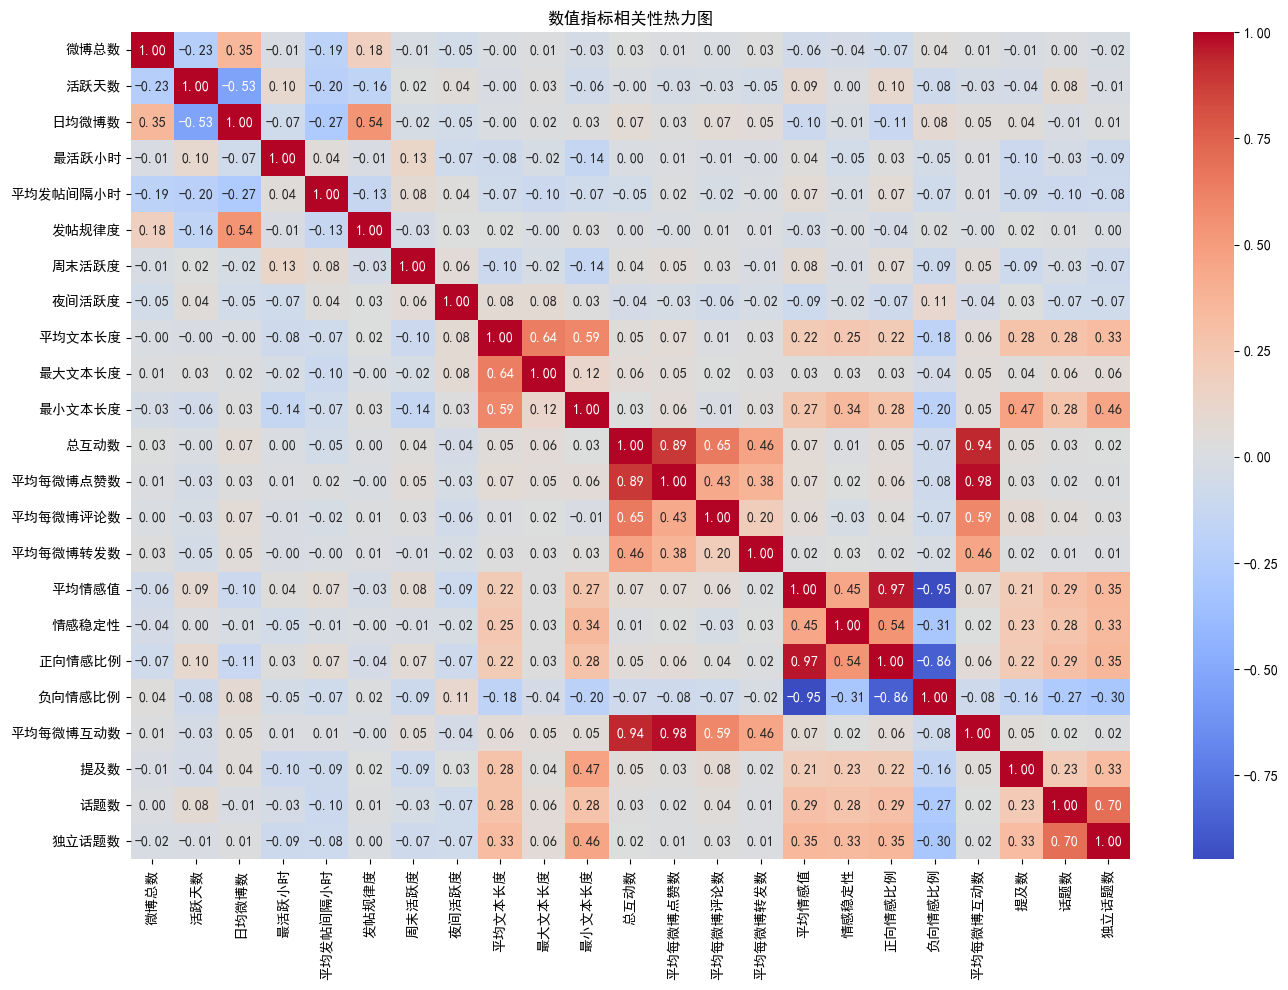

In [61]:
df_profile_numeric = df_profile[aggregate_map.keys()]

df_profile_numeric = df_profile_numeric.select_dtypes(include=["number"])

df_profile_numeric = df_profile_numeric.rename(columns=rename_map)

individual_corr_matrix = df_profile_numeric.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(individual_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("数值指标相关性热力图")
plt.tight_layout()
plt.show()

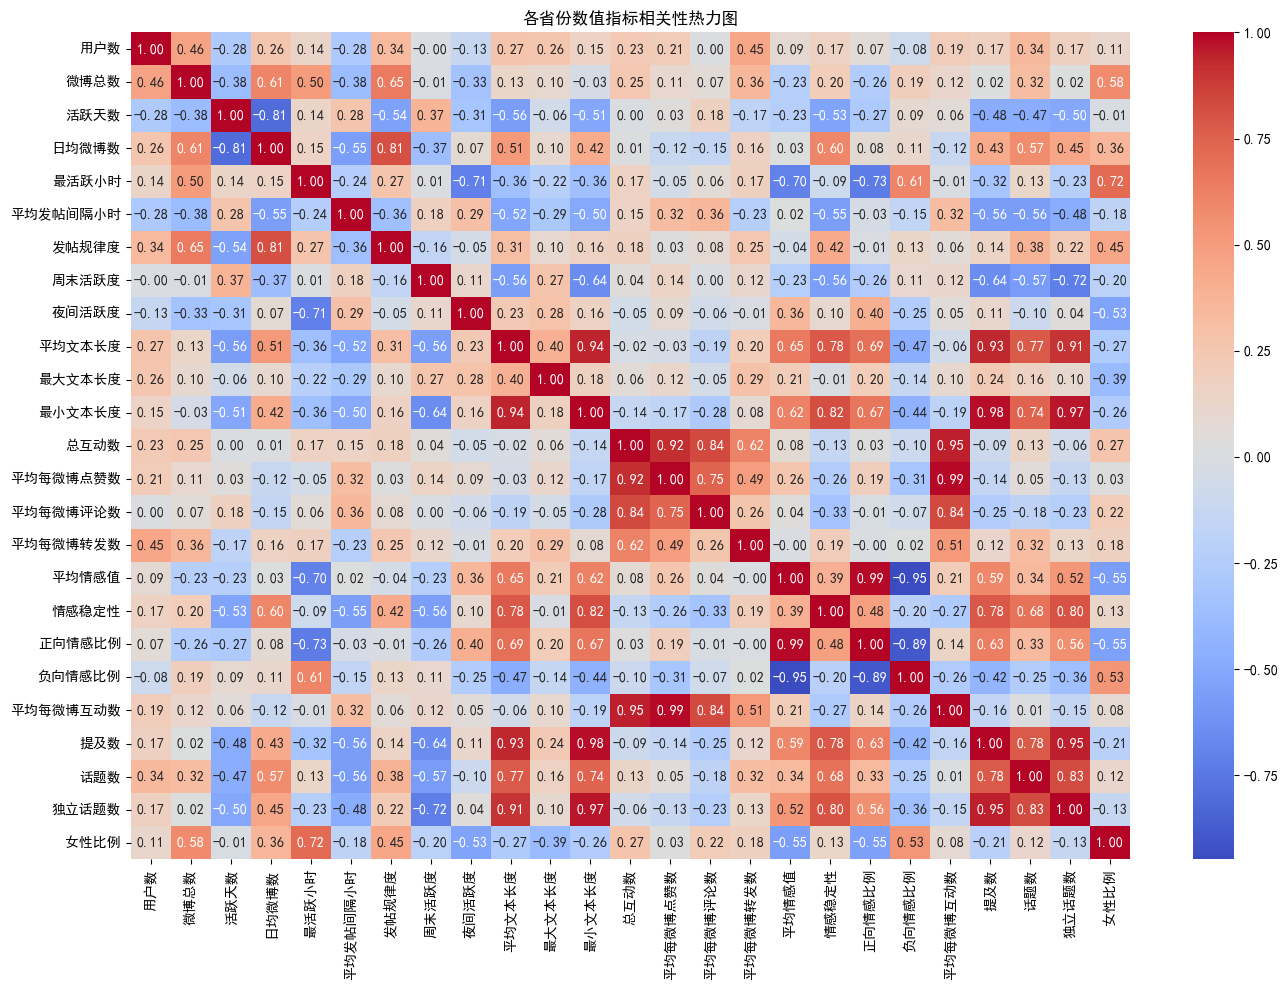

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# 计算相关性矩阵
province_corr_matrix = province_stats_numeric.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(province_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("各省份数值指标相关性热力图")
plt.tight_layout()
plt.show()

In [80]:
import numpy as np
import scipy.stats as stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

# 对每省份计算均值和置信区间
df_profile[df_profile["省份"]== "江西"]

,basic_info.uid,basic_info.screen_name,basic_info.gender,basic_info.statuses_count,basic_info.IP_location,basic_info.total_weibos,basic_info.active_days,basic_info.avg_weibos_per_day,behavior_patterns.most_active_hour,behavior_patterns.most_active_hour_ratio,...,emotional_profile.negative_ratio,social_network.social_activity_level,social_network.avg_interactions_per_weibo,social_network.mentions,social_network.mention_count,social_network.distinct_mention_count,social_network.topics,social_network.topic_count,social_network.distinct_topic_count,省份
111,1179970513,粟米喵喵DAYTOY,f,2455,江西,18,14,1.29,23,0.22,...,0.17,低活跃,1.83,"[X玖少年团肖战DAYTOY, X玖少年团肖战DAYTOY, X玖少年团肖战DAYTOY, ...",10,1,"[肖战, 肖战, 肖战, 肖战, 肖战, 肖战, 肖战, 肖战, 肖战, 肖战, 肖战, 粉...",18,4,江西
206,1260615450,实心小丸丸,f,4505,江西,49,46,1.07,22,0.16,...,0.31,低活跃,1.90,[],0,0,[一日三餐],1,1,江西
248,1287264095,嘻嘻大王呀,f,7774,江西,48,34,1.41,23,0.10,...,0.54,中活跃,2.15,[],0,0,[],0,0,江西
266,1300305442,落寂予,f,6911,江西,50,48,1.04,23,0.18,...,0.46,低活跃,0.56,[],0,0,[日常碎片plog],1,1,江西
481,1589412130,--淺深藍,f,4201,江西,32,26,1.23,23,0.19,...,0.28,低活跃,2.25,"[电影你的颜色, 电影幽灵公主]",2,2,"[扭蛋, 冬至, Merry Christmas Eve, monkeymajik, 春节档...",15,15,江西
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12947,7762665244,盒盒只想睡觉,f,342,江西,20,20,1.00,0,0.15,...,0.60,低活跃,0.70,[],0,0,[],0,0,江西
12977,7769576738,葡小萄西奥,f,775,江西,46,35,1.31,19,0.15,...,0.37,低活跃,0.54,[],0,0,"[电影好东西, 红包, 新年快乐, 上海, 哪吒影史第一, 十日终焉, 哪吒2全球票房T0P...",31,28,江西
13049,7791184809,宇宙中心小狗传音机,f,10727,江西,50,17,2.94,21,0.12,...,0.56,中活跃,2.62,[],0,0,[],0,0,江西
13130,7816663740,养一弯小月亮,f,2895,江西,50,11,4.55,9,0.12,...,0.32,低活跃,1.20,[sooyaaa_智秀],1,1,"[苦尽柑来遇见你网飞全球榜第一, 田田的练舞日记, 田田的练舞日记, 田田的练舞日记, 田田...",14,6,江西


In [112]:
# [weibo.text for weibo in user_dict["7396265427"].weibos]

# [weibo.sentiment_analysis.comprehensive_sentiment for weibo in user_dict["7396265427"].weibos]
[(weibo.text, weibo.sentiment_analysis.comprehensive_sentiment["type"]) for weibo in user_dict["7470167401"].weibos]

[('#拍下2025闪闪发光的夜# 在这个城市的夜晚，灯火璀璨，勾勒出一幅温暖的画面✨。漫步在街头，我感受到了那份属于夜的独特魅力🌌。每一盏灯都仿佛在诉说着温馨的故事，无论是街边的咖啡馆，还是高楼大厦的霓虹，我的心中都涌动着一股暖流💖。摄影是我记录生活的方式，特别是在这样闪烁的夜里📷。在每一个瞬间，我用小米手机捕捉到光影交融的美好，无论是好友间的欢笑，还是路灯下的静谧时光，都让我感受到生活的细腻💕。这些画面不仅仅是景象，更是心灵深处的共鸣💫。我想邀请你们一同参与，将2025年的夜晚用镜头铭刻，当灯光闪烁时，让我们一起感受那份扑面而来的温暖与力量🌟。在这个属于夜晚的时刻，无论何时何地，摄取下这一切美好，我相信，会为我们的生活增添无限色彩🎨。',
  '积极-喜悦'),
 ('#张凌赫代言拉面范# @拉面范 看到张凌赫代言的拉面范广告照，我瞬间被吸引了！🌟 这款拉面的汤底特别浓郁，喝一口就能感受到满满的诚意，鲜美却不油腻。🍜 面条的口感也非常棒，煮出来特别筋道，完全不像速食面，反而像现做的拉面。🍲 配料方面也很用心，蔬菜包和肉片包都分量十足，吃起来特别满足。🥗 张凌赫的代言让这款拉面更有吸引力，毕竟他可是实力与颜值并存的代言人。😍 拉面范的包装设计简约大气，拿在手里就感觉很有质感。📦 煮起来特别方便，几分钟就能搞定一顿美味，适合忙碌的现代生活。⏰ 每次吃完都感觉幸福感爆棚，真的是速食界的顶流了！💯 如果你还没试过，一定要买来尝尝，绝对不会让你失望！👍',
  '积极-喜悦'),
 ('#吉利全面统一智驾技术##吉利用AI重新定义智驾# @吉利汽车集团 我感受到吉利这次发布的智驾技术品牌，通过「世界模型」实现环境预判与风险评估的双突破，为智能出行开启了新的篇章📖。在我看来，技术赋能智驾的核心在于让车辆具备更高效的感知与决策能力🚗。通过实时捕捉和分析环境数据，车辆可以精准识别道路上的各种动态因素，比如行人、车辆和交通信号灯👀。同时，技术还能结合历史数据和实时路况，提前预测潜在风险并迅速做出最优决策🧠。这种能力不仅提升了驾驶的安全性，也大幅提高了驾驶的舒适性和效率🌟。吉利的「世界模型」正是通过模拟真实世界，提前预判可能发生的状况，从而让车辆能够更从容地应对各种复杂场景🌍。我相信，随着技术的不断进步，未来的出行方式将更加智能化和人性化，让每一次驾驶都成为一次安心、愉悦的体验💡。

In [37]:
province_stats_numeric

,用户数,微博总数,活跃天数,日均微博数,最活跃小时,平均发帖间隔小时,发帖规律度,周末活跃度,夜间活跃度,平均文本长度,...,平均每微博转发数,平均情感值,情感稳定性,正向情感比例,负向情感比例,平均每微博互动数,提及数,话题数,独立话题数,女性比例
省份,,,,,,,,,,,,,,,,,,,,,
广东,1946,3197.884892,28.249229,1.854697,14.642857,104.586362,0.004807,0.292210,0.338268,82.698474,...,0.104681,5.834111,0.484245,0.517698,0.317086,3.700601,3.083762,17.885406,8.602261,0.823227
浙江,1126,3417.188277,29.751332,1.834538,16.356128,106.449547,0.005723,0.301412,0.291181,64.807336,...,0.070444,5.765062,0.465311,0.504227,0.314440,4.403854,1.334813,15.178508,5.544405,0.868561
江苏,1040,3128.346154,29.472115,1.756856,15.807692,112.222894,0.003727,0.297673,0.291712,62.049096,...,0.090894,5.713144,0.456702,0.495096,0.325644,5.512327,1.312500,15.351923,6.062500,0.885577
上海,948,4406.188819,29.181435,1.927911,16.033755,102.362310,0.005437,0.296097,0.281392,68.589852,...,0.157669,5.650633,0.461414,0.485570,0.329051,4.707057,1.647679,14.897679,5.363924,0.863924
北京,931,4025.069817,29.487648,1.724629,16.093448,117.286584,0.006910,0.300462,0.284382,69.601622,...,0.194511,5.763169,0.466004,0.501654,0.317197,4.645134,1.230934,13.542427,5.714286,0.876477
山东,762,2944.859580,29.475066,1.778268,16.017060,106.295630,0.003769,0.293255,0.277218,58.614278,...,0.129108,5.660433,0.455630,0.487205,0.330591,4.779501,1.351706,12.751969,5.510499,0.881890
四川,597,2663.845896,30.239531,1.648191,15.916248,113.225678,0.005610,0.301742,0.310603,63.761457,...,0.245712,5.772245,0.462965,0.505561,0.318744,6.353317,1.433836,15.532663,6.038526,0.884422
湖北,541,2775.639556,28.922366,1.880314,15.889094,113.297061,0.007362,0.298614,0.306969,62.107763,...,0.041571,5.572569,0.463937,0.479353,0.349519,3.848355,1.144177,13.661738,6.035120,0.863216
福建,513,3287.411306,29.740741,1.876647,14.346979,93.641949,0.006073,0.304152,0.348869,60.927096,...,0.079181,5.499376,0.455107,0.467563,0.358519,4.011871,1.584795,12.399610,5.187135,0.879142


In [26]:
# 绘制中国地图
plot_china_map(province_stats["用户数"], title_name="各省用户数分布", series_name="用户数")